### Import libraries for experiments

In [3]:
import torch
from training_main import training_main, test
from utils import data_loading, normalization, filter_extraction, plot_results, plot_kernels
from CNN import CNN
from ScatNet import ScatNet2D
from kymatio.torch import Scattering2D
from skimage.segmentation import mark_boundaries

from lime.lime_image import LimeImageExplainer
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

from torchvision.transforms import ToTensor, Compose, Resize, Normalize, ToPILImage
from captum.attr import IntegratedGradients
import cv2

import warnings
warnings.filterwarnings('ignore')


## Data Loading and Normalization

In [4]:
# LOAD DATA
train_data, train_labels, test_data, test_labels = data_loading("./data/train/", "./data/test/")
data = train_data + test_data

# NORMALIZATION
data_transform = normalization(data)

Red ch mean =  0.2082946035683011 
Green ch mean =  0.2082298517705837 
Blue ch mean =  0.2082241406070435
Red ch std =  0.2120124417706629 
Green ch std =  0.211990008277464 
Blue ch std =  0.2119912744425196


In [5]:
print(f"Length train data: {len(train_data)}, length train labels: {len(train_labels)}")
print(f"Length test data: {len(test_data)}, length test labels: {len(test_labels)}")

Length train data: 2600, length train labels: 2600
Length test data: 600, length test labels: 600


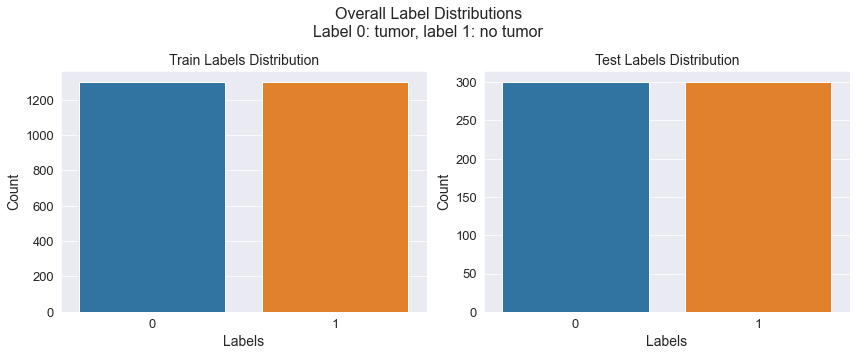

In [6]:
# Barplot to visualize the distribution of the labels 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Train labels
sns.countplot(x=train_labels, ax=ax1)
ax1.set_title('Train Labels Distribution', fontsize=14)
ax1.set_xlabel('Labels')
ax1.set_ylabel('Count')

# Test labels
sns.countplot(x=test_labels, ax=ax2)
ax2.set_title('Test Labels Distribution', fontsize=14)
ax2.set_xlabel('Labels')
ax2.set_ylabel('Count')

plt.suptitle('Overall Label Distributions\nLabel 0: tumor, label 1: no tumor', fontsize=16)
plt.tight_layout()
plt.show()


Example image

Image shape: (512, 512, 3)


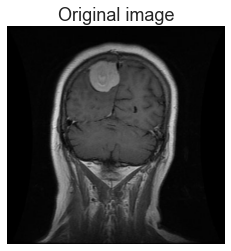

In [7]:
random.seed(42) 
image = random.sample(train_data, 1)
image = np.array(image)
image = np.squeeze(image, 0)
print(f"Image shape: {image.shape}")

plt.imshow(image)
plt.axis('off')
plt.title('Original image')
plt.show()

## CNN

In [8]:
MODEL_NAME = 'CNN'
NUM_FOLD = 10
num_epochs = 20

In [9]:
# LOAD BEST MODEL
max_val_accuracies = np.zeros([NUM_FOLD, 1])

for i in range(NUM_FOLD):
    results_string = f"./csv/{MODEL_NAME}/results_df_" + str(i) + ".csv"
    max_val_accuracies[i] = np.max(pd.read_csv(results_string)["val_acc"])
    
index = np.argmax(max_val_accuracies)

model_string = f"./models_trained/{MODEL_NAME}/checkpoint_" + str(index) + ".pth"
checkpoint = torch.load(model_string, map_location=torch.device("cpu"))
model_CNN = CNN(input_channel=3, num_classes=2)
model_CNN.load_state_dict(checkpoint["model_state_dict"])
for parameter in model_CNN.parameters():
    parameter.requires_grad = False


In [10]:
model_CNN

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (drop): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=256, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)

In [11]:
# PLOTTING RESULTS
val_accuracies = np.zeros([NUM_FOLD, num_epochs])
train_losses = np.zeros([NUM_FOLD, num_epochs])
val_losses = np.zeros([NUM_FOLD, num_epochs])
f1_scores = np.zeros([NUM_FOLD, num_epochs])

for i in range(NUM_FOLD):
    results_string = f"./csv/{MODEL_NAME}/results_df_" + str(i) + ".csv"
    val_accuracies[i] = (pd.read_csv(results_string)["val_acc"]).to_list()
    val_losses[i] = (pd.read_csv(results_string)["val_loss"]).to_list()
    train_losses[i] = (pd.read_csv(results_string)["train_loss"]).to_list()
    f1_scores[i] = (pd.read_csv(results_string)["val_f1"]).to_list()

plot_results(val_accuracies, train_losses, val_losses, f1_scores, MODEL_NAME)

Accuracy 0.9816666666666667


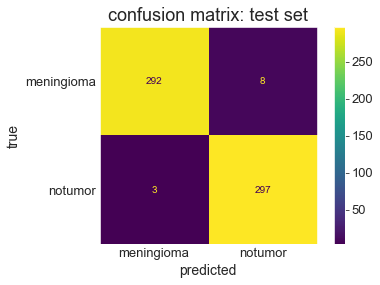

In [12]:
# TESTING
acc_CNN = test(data_transform, test_data, test_labels, model_CNN, MODEL_NAME, device='cpu')
print("Accuracy", acc_CNN)


### Extract Filters from CNN

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_CNN = model_CNN.to(device)


In [14]:
# Filter extraction
image = data_transform(image)
image = image.to(device)

single_channel = True if image.shape[0] == 1 else False
filter_extraction(model_CNN, MODEL_NAME, image, single_channel)

Total convolution layers: 4


## ScatNet 

In [15]:
MODEL_NAME = 'ScatNet'
NUM_FOLD = 10
num_epochs = 20

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
# LOAD BEST MODEL
max_val_accuracies = np.zeros([NUM_FOLD, 1])

for i in range(NUM_FOLD):
    results_string = f"./csv/{MODEL_NAME}/results_df_" + str(i) + ".csv"
    max_val_accuracies[i] = np.max(pd.read_csv(results_string)["val_acc"])
    
index = np.argmax(max_val_accuracies)

model_string = f"./models_trained/{MODEL_NAME}/checkpoint_" + str(index) + ".pth"
checkpoint = torch.load(model_string, map_location=torch.device("cpu"))

# Define best model
L = 8
J = 2
scattering = Scattering2D(J=J, shape=(128, 128), L=L)
K = 81  # Input channels for the ScatNet
scattering = scattering.to(device)
model_ScatNet = ScatNet2D(input_channels=K, scattering=scattering, num_classes=2).to(device)
model_ScatNet.load_state_dict(checkpoint["model_state_dict"])

for parameter in model_ScatNet.parameters():
    parameter.requires_grad = False

In [18]:
model_ScatNet

ScatNet2D(
  (scattering): Scattering2D()
  (lin): Linear(in_features=248832, out_features=576, bias=True)
  (classifier): Sequential(
    (0): Linear(in_features=576, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=32, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.1, inplace=False)
    (5): Linear(in_features=32, out_features=2, bias=True)
  )
)

In [19]:
# PLOTTING RESULTS
val_accuracies = np.zeros([NUM_FOLD, num_epochs])
train_losses = np.zeros([NUM_FOLD, num_epochs])
val_losses = np.zeros([NUM_FOLD, num_epochs])
f1_scores = np.zeros([NUM_FOLD, num_epochs])

for i in range(NUM_FOLD):
    results_string = f"./csv/{MODEL_NAME}/results_df_" + str(i) + ".csv"
    val_accuracies[i] = (pd.read_csv(results_string)["val_acc"]).to_list()
    val_losses[i] = (pd.read_csv(results_string)["val_loss"]).to_list()
    train_losses[i] = (pd.read_csv(results_string)["train_loss"]).to_list()
    f1_scores[i] = (pd.read_csv(results_string)["val_f1"]).to_list()

plot_results(val_accuracies, train_losses, val_losses, f1_scores, MODEL_NAME)

Accuracy 0.9666666666666667


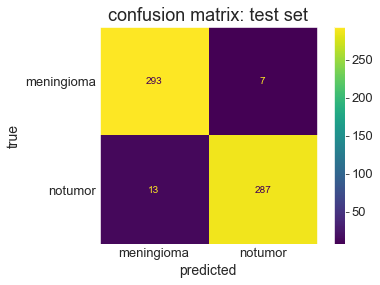

In [20]:
# TESTING
acc_ScatNet = test(data_transform, test_data, test_labels, model_ScatNet, MODEL_NAME, device='cpu')
print("Accuracy", acc_ScatNet)

### Extract Filters from ScatNet

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_ScatNet = model_ScatNet.to(device)

In [22]:
# Filter extraction
scatter = model_ScatNet.scattering
plot_kernels(J, L, scatter, MODEL_NAME)

--------------------------------------------------------------------
## INTEGRATED GRADIENTS

In [66]:
# IG SCRATCH
def ig_scratch(transformed_img, model, baseline, n_alpha):

    img = transformed_img.clone().to('cuda')
    baseline = baseline.to('cuda')
    model = model.to('cuda')

    difference_img_baseline = (img - baseline).squeeze(0).to('cuda')

    alphas = torch.linspace(0, 1, n_alpha + 1) 
    gradients_list = []

    model.eval()
    for alpha in alphas:
    
        baseline_x = baseline.unsqueeze(0).to('cuda')
        image_x = image.unsqueeze(0).to('cuda')
        difference_img_baseline = (image_x - baseline_x).to('cuda')
        input = baseline_x + alpha * difference_img_baseline

        model.zero_grad()
        input = input.clone().detach().requires_grad_(True)

        output = model(input.squeeze(0).to('cuda'))
        probs = torch.nn.functional.softmax(output, dim=1)[:,1]
        
        gradients = torch.autograd.grad(probs, input, 
                                    grad_outputs=torch.ones_like(probs),
                                    create_graph=True)[0]
        
        gradients_list.append(gradients)

    total_gradients = torch.cat(gradients_list, dim=0).to('cuda')
    grads = (total_gradients[:-1] + total_gradients[1:]) / torch.Tensor([2.0]).to('cuda')

    avg_gradients = torch.mean(grads.detach(), axis=0)
    integrated_gradients = (image - baseline) * avg_gradients

    integrated_gradients = torch.sum(torch.abs(integrated_gradients), dim=1)
    #integrated_gradients = (integrated_gradients - torch.min(integrated_gradients)) / (torch.max(integrated_gradients) - torch.min(integrated_gradients))
    integrated_gradients = np.transpose(integrated_gradients.cpu().detach().numpy(), (1, 2, 0))

    return integrated_gradients
   

In [67]:
# IG CAPTUM
def ig_captum(transformed_img, model, baseline, n_alpha):
    img = transformed_img.to('cuda')
    model = model.to('cuda')
    baseline = baseline.to('cuda')

    ig = IntegratedGradients(model)
    attributions, delta = ig.attribute(img, baseline, target=0, return_convergence_delta=True, n_steps=n_alpha)

    attributions = torch.sum(torch.abs(attributions), dim=1)
    #attributions = (attributions - torch.min(attributions)) / (torch.max(attributions) - torch.min(attributions))
    attributions = attributions.squeeze()

    return attributions

Test and plot the attributions for 3 different images from test folder.

In [58]:
random.seed(46)
num_images = 3
indices = random.sample(range(len(train_data)), num_images)

images = [train_data[i] for i in indices]
labels = [train_labels[i] for i in indices]


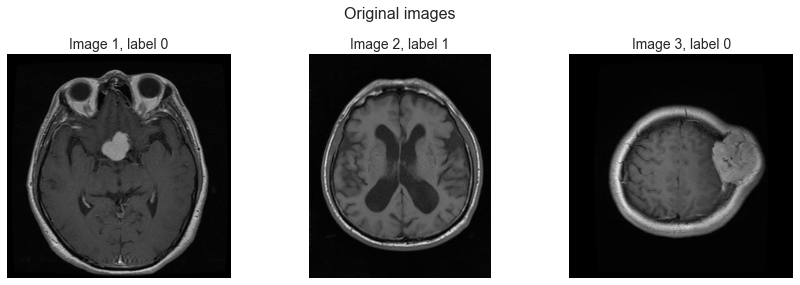

In [59]:
#Plot images
fig, axs = plt.subplots(1, num_images, figsize=(12, 4))

for i in range(num_images):
    image = images[i]
    label = labels[i]

    axs[i].imshow(image)
    axs[i].axis('off')
    axs[i].set_title(f'Image {i+1}, label {label}', fontsize=14)

plt.suptitle('Original images', fontsize=16)
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


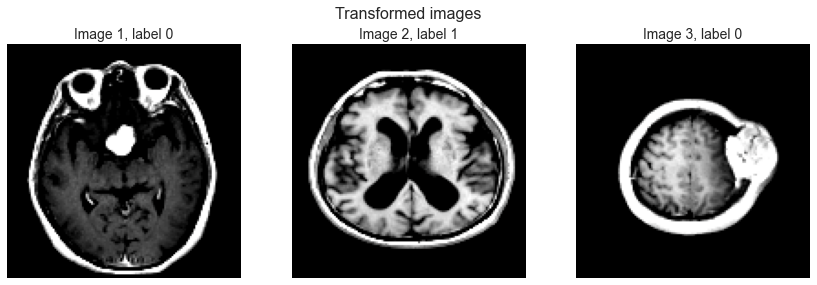

In [60]:
# Apply transform to images
for i in range(num_images):
    images[i] = data_transform(images[i]).unsqueeze(0)

# Plot
fig, axs = plt.subplots(1, num_images, figsize=(12, 4))
for i in range(num_images):
    image = np.squeeze(np.array(images[i]), 0).transpose(1, 2, 0)
    label = labels[i]
    
    axs[i].imshow(image)
    axs[i].axis('off')
    axs[i].set_title(f'Image {i+1}, label {label}', fontsize=14)

plt.suptitle('Transformed images', fontsize=16)
plt.tight_layout()
plt.show()

### Baseline choices

In [61]:
baseline_zeros = torch.zeros(1, 3, 128, 128)
baseline_uniform = torch.rand(1, 3, 128, 128)

tensor_images = torch.stack([data_transform(img) for img in train_data])
baseline_mean = torch.mean(tensor_images, dim=0, keepdim=True)

baselines = [baseline_zeros, baseline_uniform, baseline_mean]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


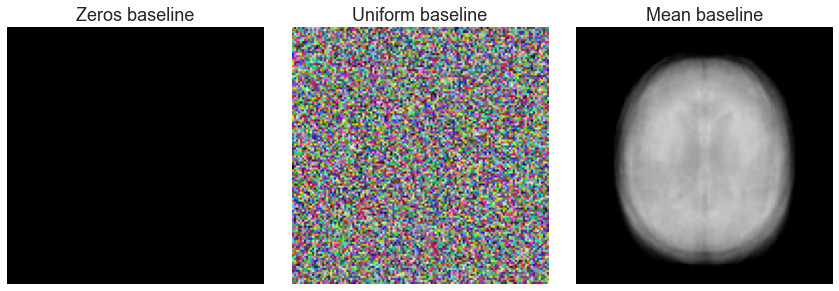

In [62]:
# Plot baselines
fig, axs = plt.subplots(1, len(baselines), figsize=(12, 4))
titles = ['Zeros baseline', 'Uniform baseline', 'Mean baseline']

for i in range(len(baselines)):
    baseline = baselines[i]

    axs[i].imshow(baseline.squeeze().permute(1, 2, 0))
    axs[i].axis('off')
    axs[i].set_title(f'{titles[i]}')

plt.tight_layout()
plt.show()

### How to plot attributions

In [70]:
# Attribution plot
def plot_attributions(image, baselines, attributions, titles):

    image = image.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()

    fig, axis = plt.subplots(len(baselines), 3, figsize=(12, 10))
    
    for i in range(len(baselines)):
        attribution = attributions[i]
        baseline_plot = baselines[i].squeeze().permute(1, 2, 0)
        ig_captum = attribution[0].cpu()
        ig_scratch = attribution[1]

        axis[i, 0].imshow(baseline_plot)
        axis[i, 0].set_xticks([])
        axis[i, 0].set_yticks([])
        axis[i, 0].set_title(titles[i], fontsize=14)

        im2 = axis[i, 1].imshow(image)
        im2 = axis[i, 1].imshow(ig_captum, cmap='hot', alpha=0.9)
        axis[i, 1].axis('off')
        axis[i, 1].set_title('IG Captum', fontsize=14)
        divider = make_axes_locatable(axis[i, 1])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im2, cax=cax, orientation='vertical')

        im3 = axis[i, 2].imshow(image)
        im3 = axis[i, 2].imshow(ig_scratch, cmap='hot', alpha=0.9)
        axis[i, 2].axis('off')
        axis[i, 2].set_title('IG Scratch', fontsize=14)

        divider = make_axes_locatable(axis[i, 2])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im3, cax=cax, orientation='vertical')
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    plt.show()

In [54]:
n_alpha = 100

### Attributions for CNN model

In [64]:
# ScatNet model
print('CNN MODEL')
for i in range(num_images):
    print(f'Image {i+1}')
    image = images[i].to('cuda')
    label = labels[i]

    model_CNN.eval()
    with torch.inference_mode():
        pred = model_CNN(image)
        
    probs = torch.softmax(pred, dim=1)
    prediction = torch.argmax(torch.softmax(pred, dim=1), dim=1)

    # model logits -> pred probs -> pred label
    print("Output logits: ", pred)
    print("Output prediction probabilities: ", probs)
    print(f'Output prediction label: {prediction} --> Prediction class: {"NO TUMOR" if prediction.cpu() == 1 else "TUMOR"}')
    print(f'Actual label: {label} --> True class: {"NO TUMOR" if label == 1 else "TUMOR"}\n')

CNN MODEL
Image 1
Output logits:  tensor([[ 4.8419, -2.3938]], device='cuda:0')
Output prediction probabilities:  tensor([[9.9928e-01, 7.1988e-04]], device='cuda:0')
Output prediction label: tensor([0], device='cuda:0') --> Prediction class: TUMOR
Actual label: 0 --> True class: TUMOR

Image 2
Output logits:  tensor([[-2.1597,  4.6655]], device='cuda:0')
Output prediction probabilities:  tensor([[0.0011, 0.9989]], device='cuda:0')
Output prediction label: tensor([1], device='cuda:0') --> Prediction class: NO TUMOR
Actual label: 1 --> True class: NO TUMOR

Image 3
Output logits:  tensor([[ 15.5090, -14.3710]], device='cuda:0')
Output prediction probabilities:  tensor([[1.0000e+00, 1.0550e-13]], device='cuda:0')
Output prediction label: tensor([0], device='cuda:0') --> Prediction class: TUMOR
Actual label: 0 --> True class: TUMOR



Image 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


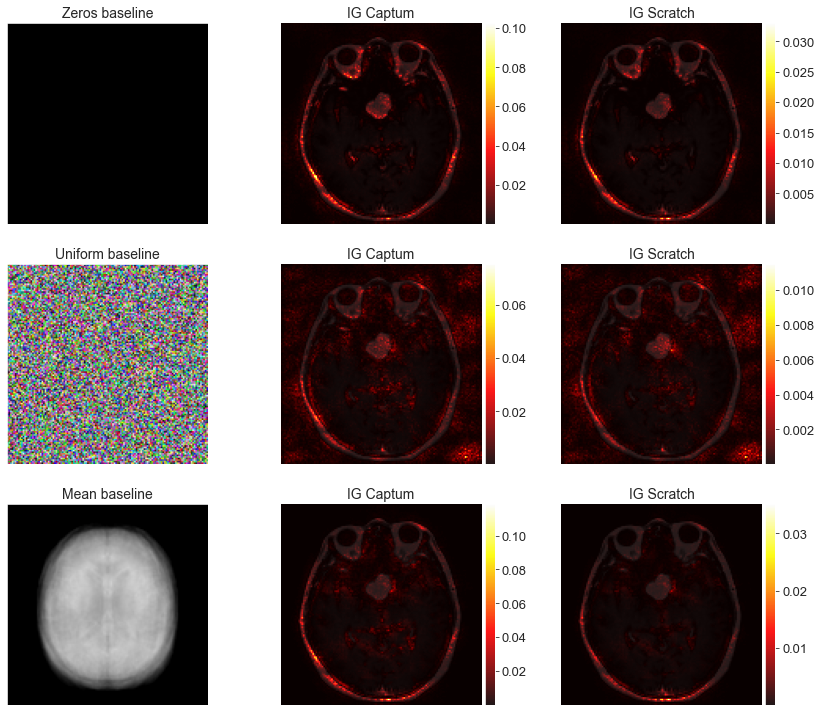

Image 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


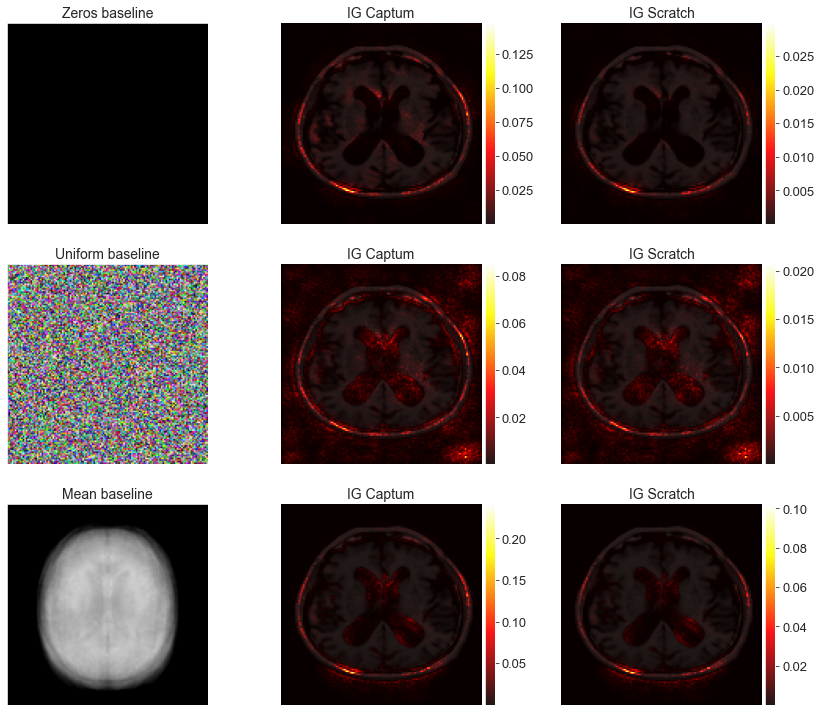

Image 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


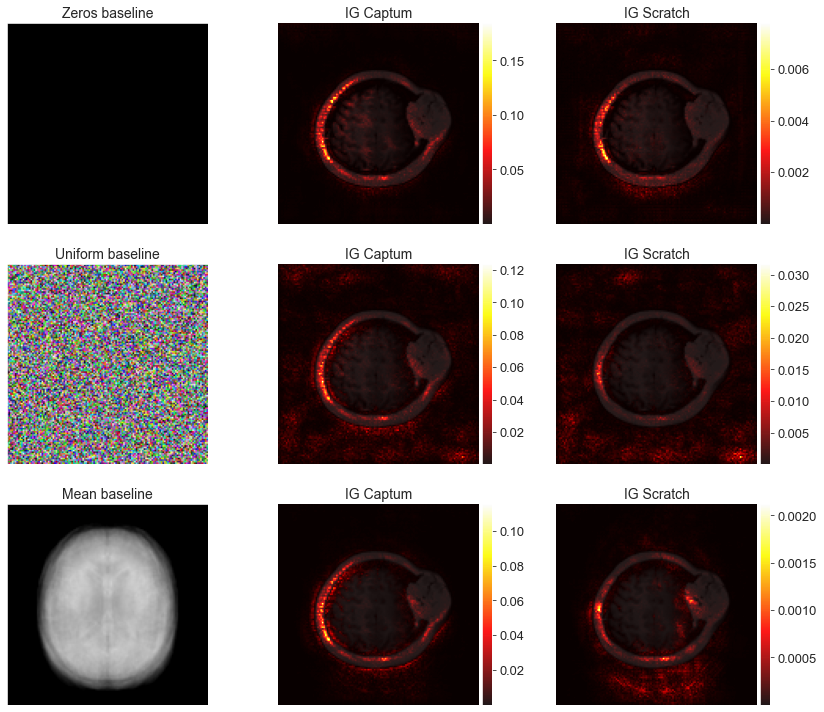

In [71]:
# Compute Integrated Gradients attributions for each baseline (Captum and scratch)
for i in range(num_images):
    print(f'Image {i+1}')
    image = images[i].to('cuda')
    
    attributions = []
    for i in range(len(baselines)):
        attribution_baseline = []

        baseline = baselines[i]
        attribution_captum = ig_captum(image, model_CNN, baseline, n_alpha)
        attribution_baseline.append(attribution_captum)
        attribution_scratch = ig_scratch(image, model_CNN, baseline, n_alpha)
        attribution_baseline.append(attribution_scratch)
        
        attributions.append(attribution_baseline)

    plot_attributions(image, baselines, attributions, titles)

### Attributions for ScatNet model

In [34]:
# ScatNet model
print('SCATNET MODEL')
for i in range(num_images):
    print(f'Image {i+1}')
    image = images[i].to('cuda')
    label = labels[i]

    model_ScatNet.eval()
    with torch.inference_mode():
        pred = model_ScatNet(image)
        
    probs = torch.softmax(pred, dim=1)
    prediction = torch.argmax(torch.softmax(pred, dim=1), dim=1)

    # model logits -> pred probs -> pred label
    print("Output logits: ", pred)
    print("Output prediction probabilities: ", probs)
    print(f'Output prediction label: {prediction} --> Prediction class: {"NO TUMOR" if prediction.cpu() == 1 else "TUMOR"}')
    print(f'Actual label: {label} --> True class: {"NO TUMOR" if label == 1 else "TUMOR"}\n')

SCATNET MODEL
Image 1
Output logits:  tensor([[4.7375, 0.1846]], device='cuda:0')
Output prediction probabilities:  tensor([[0.9896, 0.0104]], device='cuda:0')
Output prediction label: tensor([0], device='cuda:0') --> Prediction class: TUMOR
Actual label: 0 --> True class: TUMOR

Image 2
Output logits:  tensor([[-1.8267,  4.4021]], device='cuda:0')
Output prediction probabilities:  tensor([[0.0020, 0.9980]], device='cuda:0')
Output prediction label: tensor([1], device='cuda:0') --> Prediction class: NO TUMOR
Actual label: 1 --> True class: NO TUMOR

Image 3
Output logits:  tensor([[16.0717, -4.0072]], device='cuda:0')
Output prediction probabilities:  tensor([[1.0000e+00, 1.9047e-09]], device='cuda:0')
Output prediction label: tensor([0], device='cuda:0') --> Prediction class: TUMOR
Actual label: 0 --> True class: TUMOR



Image 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


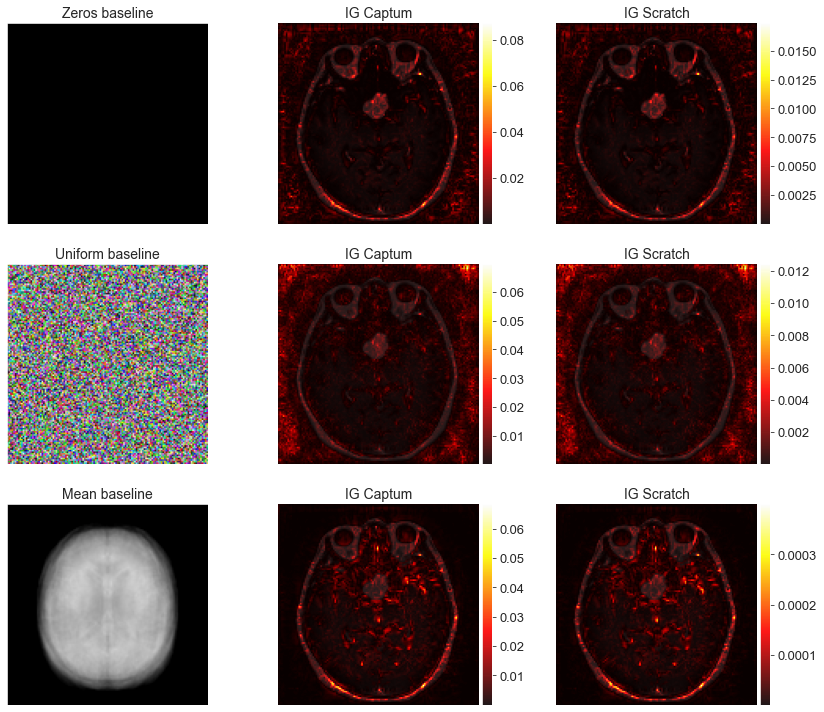

Image 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


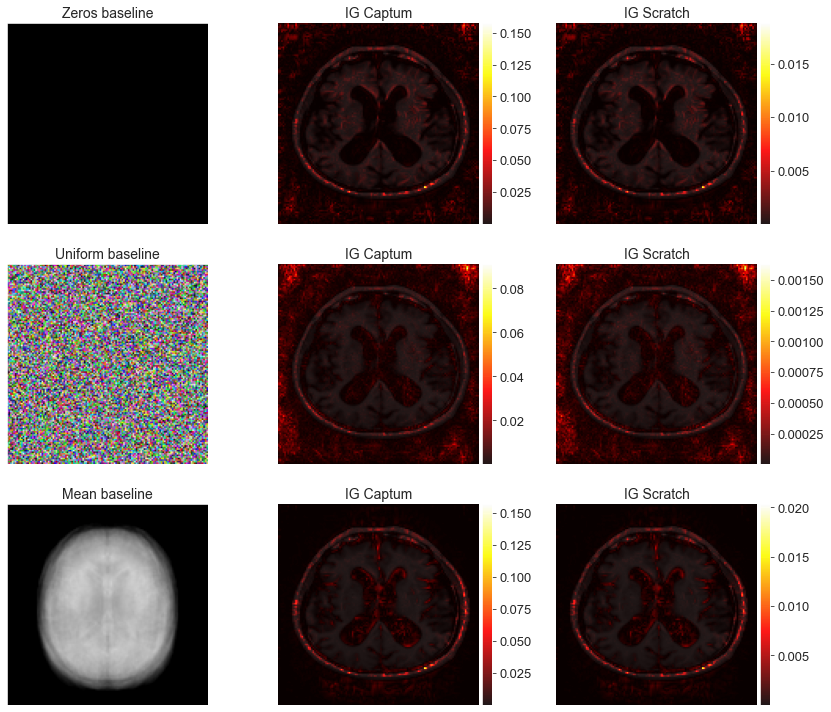

Image 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


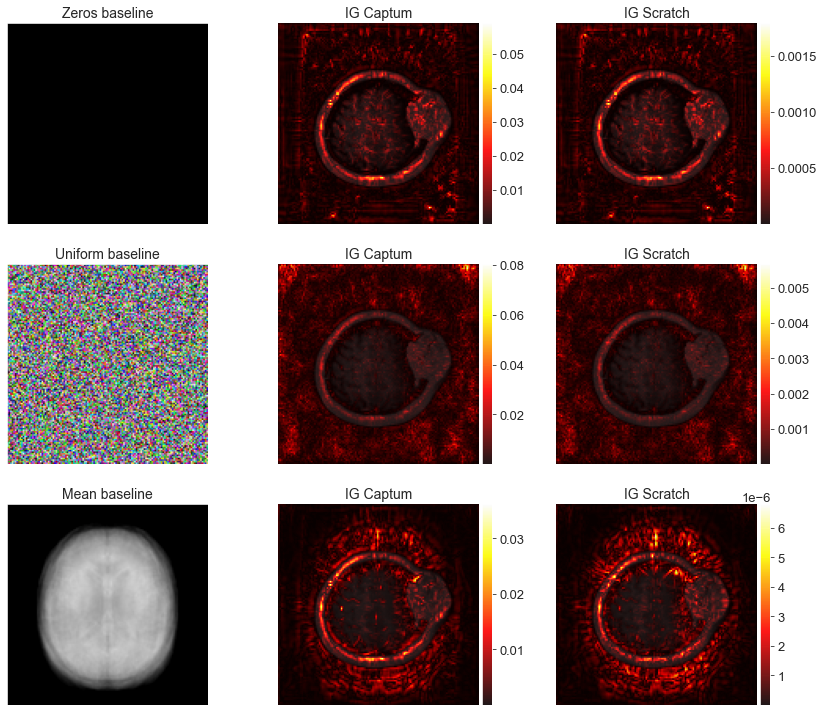

In [72]:
# Compute Integrated Gradients attributions for each baseline (Captum and scratch)
for i in range(num_images):
    print(f'Image {i+1}')
    image = images[i].to('cuda')
    
    attributions = []
    for i in range(len(baselines)):
        attribution_baseline = []

        baseline = baselines[i]
        attribution_captum = ig_captum(image, model_ScatNet, baseline, n_alpha)
        attribution_baseline.append(attribution_captum)
        attribution_scratch = ig_scratch(image, model_ScatNet, baseline, n_alpha)
        attribution_baseline.append(attribution_scratch)
        
        attributions.append(attribution_baseline)

    plot_attributions(image, baselines, attributions, titles)

--------------------------------------------------------------------
## LIME

In [36]:
# Attribution plot
def plot_lime(image, img1, img2):

    # REMOVE WHEN THERE ARE MORE THAN 1 IMAGE --> TO AVOID REMOVE i VARIABLE EVERYWHERE
    image = image.reshape(1, 128, 128, 3)
    img1 = img1.reshape(1, 128, 128, 3)
    img2 = img2.reshape(1, 128, 128, 3)
    # REMOVE WHEN THERE ARE MORE THAN 1 IMAGE  --> TO AVOID REMOVE i VARIABLE EVERYWHERE

    fig, axis = plt.subplots(len(image), 3, figsize=(12, 10))

    for i in range(image.shape[0]):

        axis[0].imshow(image[i])  # .cpu().detach().numpy())
        axis[0].set_xticks([])
        axis[0].set_yticks([])
        # axis[i, 0].set_title(titles[i], fontsize=14)

        # im2 = axis[i, 1].imshow(image)
        im2 = axis[1].imshow(img1[i].reshape(128, 128, 3), cmap='inferno', alpha=0.9)
        axis[1].axis('off')
        axis[1].set_title('Mask Positive', fontsize=14)
        # divider = make_axes_locatable(axis[1])
        # cax = divider.append_axes('right', size='5%', pad=0.05)
        # fig.colorbar(im2, cax=cax, orientation='vertical')

        # im3 = axis[i, 2].imshow(image)
        im3 = axis[2].imshow(img2[i].reshape(128, 128, 3), cmap='inferno', alpha=0.8)
        # im3 = axis[i, 2].imshow(ig_scratch.squeeze(0).permute(1,2,0).cpu(), cmap='jet', alpha=0.9)
        axis[2].axis('off')
        axis[2].set_title('MAsk Positive and Negative', fontsize=14)

        # divider = make_axes_locatable(axis[2])
        # cax = divider.append_axes('right', size='5%', pad=0.05)
        # fig.colorbar(im3, cax=cax, orientation='vertical')

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    plt.show()

In [37]:
def batch_predict_CNN(images):
    model_CNN.eval()
    data = torch.tensor(images).view(images.shape[0],images.shape[3],images.shape[1],images.shape[2])
    data = data.to('cuda')
    logits = model_CNN(data)
    probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

def batch_predict_ScatNet(images):
    model_ScatNet.eval()
    data = torch.tensor(images).view(images.shape[0],images.shape[3],images.shape[1],images.shape[2])
    data = data.to('cuda')
    logits = model_ScatNet(data)
    probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [77]:
images = torch.empty(len(test_data), 3, 128, 128)

for i, img in enumerate(test_data):
    images[i] = data_transform(img)

background = images[:100]
test_images = images[100:106]
test_images = test_images.to('cuda')

lime_explainer = LimeImageExplainer(kernel_width=0.25, #kernel=None,
                                    verbose=False, feature_selection='auto', random_state=None)

## CNN Lime

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


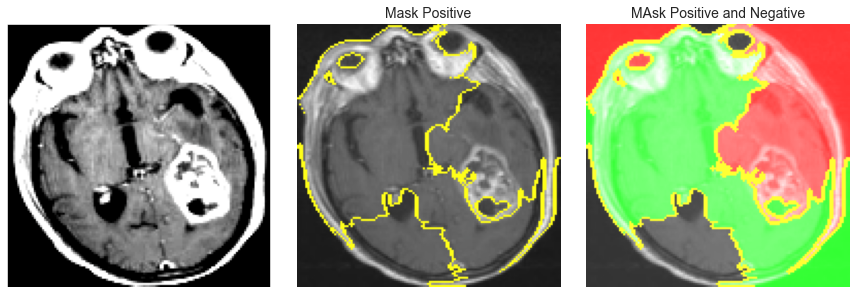

In [78]:
image_original = np.transpose(np.array(background[1]), (1, 2, 0))

lime_inst_exp = lime_explainer.explain_instance(image_original, batch_predict_CNN, num_features=8)

temp, mask = lime_inst_exp.get_image_and_mask(lime_inst_exp.top_labels[0], positive_only=True, num_features=5,
                                            hide_rest=False)
temp = (temp - temp.min()) / (temp.max() - temp.min())
img1 = mark_boundaries(temp, mask)

temp, mask = lime_inst_exp.get_image_and_mask(lime_inst_exp.top_labels[0], positive_only=False, num_features=20,
                                            hide_rest=False)

temp = (temp - temp.min()) / (temp.max() - temp.min())
img2 = mark_boundaries(temp, mask)

plot_lime(image_original, img1, img2)

## ScatNet LIME

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


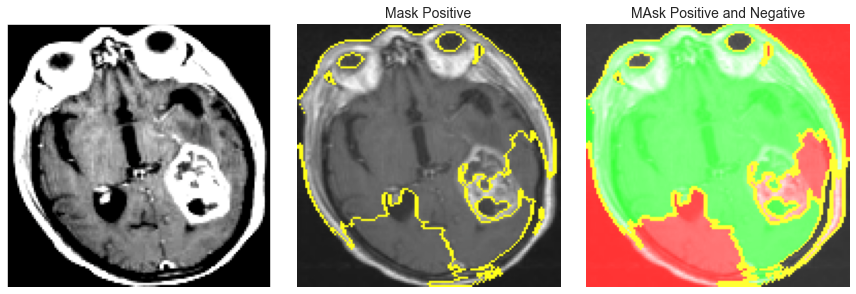

In [40]:
image_original = np.transpose(np.array(background[1]), (1, 2, 0))

lime_inst_exp = lime_explainer.explain_instance(image_original, batch_predict_ScatNet, num_features=8)

temp, mask = lime_inst_exp.get_image_and_mask(lime_inst_exp.top_labels[0], positive_only=True, num_features=5,
                                            hide_rest=False)
temp = (temp - temp.min()) / (temp.max() - temp.min())
img1 = mark_boundaries(temp, mask)

temp, mask = lime_inst_exp.get_image_and_mask(lime_inst_exp.top_labels[0], positive_only=False, num_features=20,
                                            hide_rest=False)

temp = (temp - temp.min()) / (temp.max() - temp.min())
img2 = mark_boundaries(temp, mask)

plot_lime(image_original, img1, img2)

--------------------------------------------------------------------
## SHAP

### SHAP CNN

In [41]:
import shap
background = background.to('cuda')

e = shap.GradientExplainer(model_CNN, background)
shap_values = e.shap_values(test_images)

In [42]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


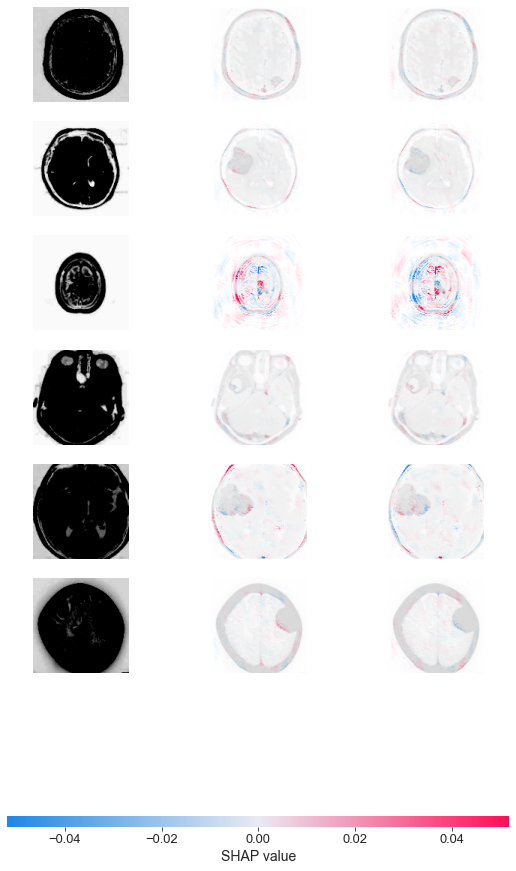

In [43]:
shap.image_plot(shap_numpy, -test_numpy, )

### SHAP ScatNet

In [44]:
e = shap.GradientExplainer(model_ScatNet, background)
shap_values = e.shap_values(test_images)

In [45]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


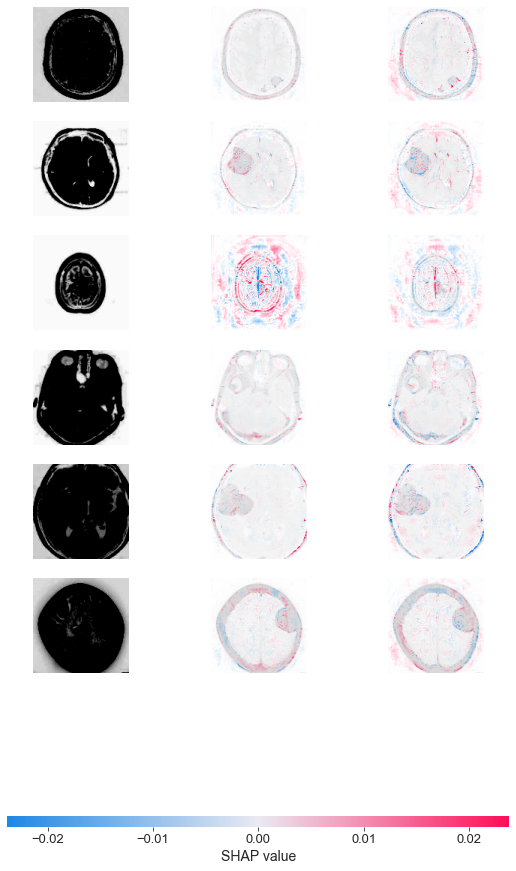

In [46]:
shap.image_plot(shap_numpy, -test_numpy, )